# ax_pie()
- llamada luego por plt_pie o por quien sea

## Vamos a retomar ax_pie directamente de plt_chart module
- por ahora detalles más abajo...

## TO-DO
- Hemos completado la mayoría de los TO-DOs anteriormente planteados, pero queda ahora
- Profundizar el tema de canvas_color (no sé si ponerlo o no)
- El tema de Title color (ponerlo, tomarlo)
- El tema de Style () y canvas color luego de ver las clases de dataviz
> TODOS eso temas de colores y estilo lo vamos a sacar una vez que analicemos el curso y sitio dataviz.

## Primer TO-DO a hacer ahora el tema de ELIMINAR los colores extremos en paletas sequential
- color_list = mtints.get_color_hex_list_from_pltt(palette, int(len(sr) + 2))[1:]
  - Basandonos en el punto de abajo lo que voy a hacer es hacer una sola lista grandota con todas las paletas MENOS las qualitatives
  - Si el cmap está en esa listota evito los extremos
  - Si no esta en esa lista es por que es Qualitative o es cualquier cmap nuevo o desconocido por mpl y por los dicts de JM
- tengo que importar la lista de paletas clasificadas por tipo ... por vemos
- OJO .. footer 'None' NO anda - DONE

## Nota sobre Paletas (colormaps()) - 26/8/25
- Tengo que probar invocar paletas no solo por nombre sinto también como objetos (que van a estar en una variable)
- para ello voy a leer e investigar un poco
- Tengo que continuar con el curso de visualization y el site data-to-viz
> Tengo que hacer palette que sea válido un str: cmap_name o un [list of colors] tal como es el original plt.pie()

In [ ]:
## Standard Libs
from typing import Optional

# Third-party Libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Local Libs
import jm_utils.data.pd_functions as pdfuncs
import jm_utils.data.mpl_tints as mtints

In [ ]:
## Paletas por tipo
pltts_by_cat = mtints.CMAP_NAMES_BY_CAT
for k, (pltts, desc) in pltts_by_cat.items():
    print(f"Categoría: {k}, Paletas: {pltts[2:9]}")

In [ ]:
# df, from xls spreadsheet
try:
    spreadsheet = r"C:\Users\jm\Documents\__Dev\PortableGit\__localrepos\365DS_jm\3_statistics\2_13_Practical_Ex_Descriptive_Stats.xlsx"    # Casa
    with open(spreadsheet) as f:
        pass
except FileNotFoundError:
    spreadsheet = r"D:\git\PortableGit\__localrepos\365DS_jm\3_statistics\2_13_Practical_Ex_Descriptive_Stats.xlsx"                         # Office

df = pd.read_excel(spreadsheet, skiprows=4, usecols='B:J,L:AA', index_col='ID')
df

## Last Version Ver. 6.
-ax and plt coherentes...

In [ ]:
def ax_plt_pie6(
    ax: plt.Axes,
    data: pd.Series | np.ndarray | dict | list | set | pd.DataFrame,
    value_counts: Optional[bool] = False,
    dropna: Optional[bool] = True,
    order: Optional[str] = 'desc',                  # 'asc', 'desc', 'ix_asc', 'ix_des', None?
    scale: Optional[int] = 1,                       # 1 to 16
    title: Optional[str | None] = None,
    kind: Optional[str] = 'pie',                    # 'pie', 'donut'
    palette: Optional[list] = 'Blues_r',
    startangle: Optional[float] = 90,
    pcts_labels: Optional[str | None] = 'inside',   # None, 'inside', 'values in', 'mixed', 'outside'
    pct_decimals: Optional[int] = 1,
    labels_rotatation: Optional[float] = 0,
    labels_color: Optional[str] = 'black',
    legends: Optional[str | None] = None,           # None, 'base', 'full'    
    legends_title: Optional[str] = None,
    show_stats_subtitle: Optional[bool]= True,
    footer: Optional[str | None] = "Pie/Donut Chart from jm_utils.data.plt_charts",
) -> plt.Axes:

    ## ----------------------- Data Preparation ------------------------------------------------------------------------------------------------------------------ 
    # Get the data to graph: use controls and processing that get_fdt() does to obtain the series to graph (first column: 'Frequency')
    fdt = pdfuncs.get_fdt(data, value_counts=value_counts, order=order,
                  dropna=False, na_position='value', na_aside_calc=False, include_flat_relatives=False, include_pcts=False)
        # - dropna=False            -> So that it doesn't remove NaNs, and then handle them
        # - na_aside_calc=False     -> So that it allows me to sort the nan value with na_position='value'
        # - na_position='value'     -> So that it allows me to sort the nan value within the list of values either desc or asc (according to order)
        # - We do not include relative flat rates or percentages. We calculate the percentages before presenting them.

    # cat_name: lo puedo usar luego in title y en legend titel
    cat_name = fdt.index.name                       # Category name <- from fdt.index.name (could be 'Index' Warn!)

    sr = fdt.iloc[:, 0]                             # Get the Series with the frequencies (count)
    # As sr.index build the legends: If I want to change the legends, I'll have to see how I modify this sr.index (must be done previously of run this funct)
         
    # Handling of nans since they are presented in the subtitle, whether or not they appear in the graph
    total_label = "Total (w/nulls)"                 # total_label to be presented in subtitle (inital value w/nulls)
    
    if pd.isna(sr.index).any():                     # There is np.nan [NaN] index, nans values
        n_nans = sr[np.nan]
        if dropna:                                  # No NaNs in the graph
            sr = sr.drop(np.nan, errors='ignore')   # Drop NaN row from the DataFrame
            total_label = "Total (wo/nulls)"        # The total will be calculated wo/NaNs (likewise, n_nans will appear in the subtitle.)
    else:                                           # No np.nan row
        n_nans = 0

    total = sr.sum()                                # Get the total sum() of frequency (count) of all categories to display

    # Validate maximum categories
    if len(sr) > 9:
        raise ValueError(f"Data contains {len(sr)} categories. Maximum allowed is 9 categories.")
    
    ## ----------------------- Set sizes (based on scale), wedgeprops (based on kind) and colors (based on palette) ------------------------------------------------- 
    # Build graphs size, and fonts size from scale, and validate scale from 1 to 9.
    if scale < 1 or scale > 16:
        raise ValueError(f"Invalid value for 'scale': {repr(scale)}. Expected a value between 1 and 16 inclusive.")
    else:
        scale = round(scale)
    
    # Calculate font sizes based scale
    multiplier= scale + 5
    labels_size = multiplier * 1.1
    title_size = multiplier * 1.6

    # Configure wedge properties for donut or pie chart
    if kind.lower() == 'pie':
        wedgeprops = {'edgecolor': 'white', 'linewidth': 0.5}
    elif kind.lower() == 'donut':
        wedgeprops = {'width': 0.55, 'edgecolor': 'white', 'linewidth': 1}
    else:
        ValueError(f"Invalid value for 'kind': {repr(kind)}. Expected one of: 'pie', 'donut'.")

    # Define colors
    pltts_by_cat = mtints.CMAP_NAMES_BY_CAT.copy()
    not_qualitative_cmaps = [cmap for key in pltts_by_cat.keys() if key != 'Qualitative' for cmap in pltts_by_cat[key][0]]
    if palette:
        if palette in not_qualitative_cmaps:
            color_list = mtints.get_hexcolor_list_from_pltt(palette, len(sr) + 2)[1:]
        else:
            color_list = mtints.get_hexcolor_list_from_pltt(palette, len(sr))

    else:
        color_list = None                               # Default system colors

    ## ----------------------- Build the chart (pie or donut) ------------------------------------------------- 
    # _make_autopct() auxiliar function for different autopcts
    def _make_autopct(values, inside_lanels):             # A python Closure
        value_iterator = iter(values)    
        def my_autopct(pct):
            next_value = next(value_iterator)
            info = f"{next_value:,}\n{pct:.{pct_decimals}f}%"
            if inside_lanels:
                info = f"{sr.loc[sr == next_value].index[0]}\n" + info
            return info

        return my_autopct
    
    # Set different values of labels and autopct acoording pcts_labels parameter (special case 'outside')
    if pcts_labels is None:
        labels = None
        autopct_func = None
    elif pcts_labels == 'inside':
        labels = None
        autopct_func = _make_autopct(sr.values, inside_lanels=True)
    elif pcts_labels == 'values in':
        labels = None
        autopct_func = _make_autopct(sr.values, inside_lanels=False)
    elif pcts_labels == 'mixed':
        labels = sr.index
        autopct_func = _make_autopct(sr.values, inside_lanels=False)
    elif pcts_labels == 'outside':
        # Special case where we build the chart here
        wedges, _ = ax.pie(sr, wedgeprops=wedgeprops, colors=color_list, startangle=startangle)
        bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
        kw = dict(arrowprops=dict(arrowstyle="-"), bbox=bbox_props, zorder=0, va="center")

        # Build the labels. Annotations and legend in same label (External)
        labels = [f"{sr.loc[sr == value].index[0]}\n{value:,}\n({round(value / total * 100, pct_decimals)} %)"
                  for value in sr.values]

        for i, p in enumerate(wedges):
            ang = (p.theta2 - p.theta1)/2. + p.theta1
            y = np.sin(np.deg2rad(ang))
            x = np.cos(np.deg2rad(ang))
            horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
            connectionstyle = f"angle,angleA=0,angleB={ang}"
            kw["arrowprops"].update({"connectionstyle": connectionstyle})
            ax.annotate(labels[i], xy=(x, y), xytext=(1.1*np.sign(x), 1.1*y),
                    horizontalalignment=horizontalalignment, fontsize=labels_size, **kw)
    else:
        raise ValueError(f"Invalid value for 'pcts_labels': {repr(pcts_labels)}. Expected one of: None, 'inside', 'mixed', 'outside'.")
    
    # Build the chart for the rest of pcts_labels options different from 'outside'. (None, 'inside', 'mixed') 
    #   (It is more direct to run it with an if and not create another internal aux function because the parameterization is very heavy)
    if pcts_labels != 'outside':
        ax.pie(x = sr,
            wedgeprops = wedgeprops,
            labels = labels,
            rotatelabels = True,
            autopct = autopct_func,
            colors = color_list,
            startangle = startangle,
            textprops = dict(size = labels_size,
                             color = labels_color,
                             rotation = labels_rotatation,
                             weight = 'semibold'),)

    # Display legends based on the 'legends' parameter 
    if legends is not None:
        if legends == 'base':
            color_legends = sr.index
        elif legends == 'full':
            color_legends = [f"{sr.index[i]} \n| {value:,} | {round(value / total * 100, pct_decimals)} %"
                           for i, value in enumerate(sr.values)]
        else:
            raise ValueError(f"Invalid value for 'legends': {repr(legends)}. Expected one of: None, 'base', 'full'.")

        ax.legend(color_legends,
                  loc='best',
                  prop={'size': labels_size},
                  title=legends_title,
                  title_fontproperties = {'size':labels_size, 'weight': 'bold'},
                  bbox_to_anchor=(1, 0.9),
        )
            
    # Buid and display title, subtitle, and footer
    if not (isinstance(title, str)):
        title = f"Pie/Donut Chart ({cat_name})"
    ax.set_title(title, fontsize=title_size, fontweight='bold', loc='left')

    if show_stats_subtitle:                              # Enhanced footer with statistics
        n_categories = len(sr)                  # len(categories)
        top_2_pct = (sr.head(2).sum() / total * 100) if n_categories >= 2 else 100

        stats = f"{total_label} {total:,} | Categories: {n_categories} | First 2: {top_2_pct:.1f}% | Nulls (nan): {n_nans}"
        ax.text(0, 1, stats, transform=ax.transAxes, fontsize=title_size * 0.65, ha='left', va='top', color='dimgray')

    if footer and isinstance(footer, str):
        print(footer)
        ax.text(0, 0.01, footer, 
                transform=ax.transAxes,             # Coordinates relative to the axes (0-1)
                fontsize=title_size * 0.65,
                ha='left',                      
                va='bottom',                    
                style='italic',
                color='dimgray')

    return ax

In [ ]:
def plt_pie6(
    data: pd.Series | np.ndarray | dict | list | set | pd.DataFrame,
    value_counts: Optional[bool] = False,
    dropna: Optional[bool] = True,
    order: Optional[str] = 'desc',                      # 'asc', 'desc', 'ix_asc', 'ix_des', None?
    scale: Optional[int] = 1,                           # 1 to 16
    figsize: Optional[tuple[float, float]] = None,
    title: Optional[str] = None,
    kind: Optional[str] = 'pie',                        # 'pie', 'donut'
    palette: Optional[list | None] = 'Blues_r',         # None -> default palette rcParams
    startangle: Optional[float] = 90,
    pcts_labels: Optional[str] = 'inside',              # None, 'inside', 'values in', 'mixed', 'outside'
    pct_decimals: Optional[int] = 1,
    labels_rotatation: Optional[float] = 0,
    labels_color: Optional[str] = 'black',
    legends: Optional[str | None] = None,               # None, 'base', 'full'
    legends_title: Optional[str] = None,
    show_stats_subtitle: Optional[bool]= True,
    footer: Optional[str | None] = "Pie/Donut Chart from jm_utils.data.plt_charts",
    canvas_color: Optional[str | None] = None           # E.g. 'lightgray', '#eafff5'
) -> tuple[plt.Figure, plt.Axes]:
    
    # Build graphs size, and fonts size from scale, and validate scale.
    if scale < 1 or scale > 16:
        raise ValueError(f"Invalid value for 'scale': {repr(scale)}. Expected a value between 1 and 16 inclusive.")
    else:
        scale = round(scale)

    # Calculate figure dimensions
    if figsize is None:
        multiplier = scale + 5
        w_base, h_base = 1.25, 0.7
        width, height = w_base * multiplier, h_base * multiplier
        figsize = (width, height)
    else:
        width, height = figsize
        scale = (width + height) / 2.5

    # Base fig definitions
    fig, ax = plt.subplots(figsize=figsize, subplot_kw=dict(aspect="equal"), facecolor=(canvas_color))

    ax_plt_pie6(ax, data, value_counts, dropna, order, scale, title, kind, palette, startangle, pcts_labels,
                pct_decimals, labels_rotatation, labels_color, legends, legends_title, show_stats_subtitle, footer)    
                
    return fig, ax

In [ ]:
## Paletas por tipo
pltts_by_cat = mtints.CMAP_NAMES_BY_CAT
print(pltts_by_cat.keys())
# for k, (pltts, desc) in pltts_by_cat.items():
#     print(f"Categoría: {k}, Paletas: {pltts[2:9]}")

not_qualitative_cmaps1 = (pltts_by_cat['Cyclic'][0] + pltts_by_cat['Diverging'][0] + pltts_by_cat['Miscellaneous'][0] + pltts_by_cat['Perceptually Uniform Sequential'][0] +
                         pltts_by_cat['Single-Hue Sequential'][0] + pltts_by_cat['Multi-Hue Sequential'][0] + pltts_by_cat['Other Sequential'][0])
                         

not_qualitative_cmaps2 = [pltt for pltt in (pltts_by_cat[key][0] for key in pltts_by_cat.keys() if key != 'Qualitative')]
not_qualitative_cmaps3 = [pltts_by_cat[key][0] for key in pltts_by_cat.keys() if key != 'Qualitative']
not_qualitative_cmaps4 = (pltt for pltt in (pltts_by_cat[key][0] for key in pltts_by_cat.keys() if key != 'Qualitative'))
not_qualitative_cmaps5 = [cmap for key in pltts_by_cat.keys() if key != 'Qualitative' for cmap in pltts_by_cat[key][0]]

# not_qualitative_cmaps3 = filter(lambda pltts_by_cat[key][0]: pltts_by_cat[key][0] if key != 'Qualitative' else None, pltts_by_cat.keys())

# not_qualitative_cmaps2 == not_qualitative_cmaps3
# for el in not_qualitative_cmaps5:
#     print(el)

In [ ]:
# print(df.columns)
# fig = plt_pie6(df['Mortgage'], value_counts=True, scale=4, dropna=False)  #, order='desc', scale=6, kind='donut', pcts_labels='inside', legends='full', legends_title='Education Level', title='Education Level of Survey Participants', footer='Source: 2_13_Practical_Ex_Descriptive_Stats.xlsx', canvas_color='#f0f0f0')
fig = plt_pie6(df['Source'], value_counts=True, scale=3, dropna=False, palette='Blues_r', pcts_labels='outside', startangle=90)  #, order='desc', scale=6, kind='donut', pcts_labels='inside', legends='full', legends_title='Education Level', title='Education Level of Survey Participants', footer='Source: 2_13_Practical_Ex_Descriptive_Stats.xlsx', canvas_color='#f0f0f0')

## Notas sobre paletas (retomo)
- invocarlas por nombre o por objeto
    1. creamos una paleta propia de mode de tener el objeto y el nombre
    2. creamos una función que la llame de las dos maneras (la función mía de plot_palettes solo la llama por nombre)

In [14]:
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt

colors = ['k','#66b3ff', (0, 0.1, 0.2, 0.3), 'xkcd:purple', 'C3']
# make a mpl cmap
cmap1 = mpl.colors.ListedColormap(colors)
mpl.colormaps.register(cmap1, name='cmap1_name', force=True)

C:\Users\jm-mtm\AppData\Local\Temp\ipykernel_9460\3702005102.py:8: UserWarning: Overwriting the cmap 'cmap1_name' that was already in the registry.
  mpl.colormaps.register(cmap1, name='cmap1_name', force=True)


In [16]:
def plotcmap(pltt):
    fig, ax = plt.subplots(figsize=(4, 2))
    im = ax.imshow([range(100)], cmap=pltt, aspect='auto')
    fig.colorbar(im, ax=ax)
    # plt.show()

Colormap 'cmap1_name' is registered successfully.


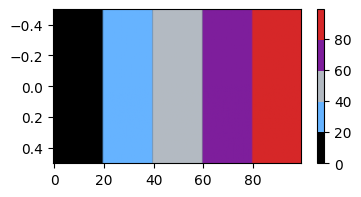

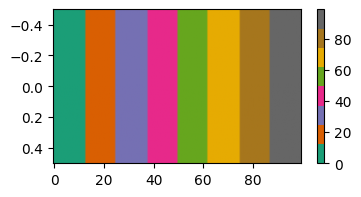

In [19]:
if 'cmap1_name' in mpl.colormaps():
    
    print("Colormap 'cmap1_name' is registered successfully.")

dir(cmap1)
plotcmap(cmap1)
plotcmap('Dark2')


In [ ]:
stop()

In [ ]:
# import time
# my_time = int(input("enter the time in seconds:"))
# for x in range(my_time,0,-1):
#     seconds = x % 60
#     minutes = int(x/60)%60
#     hours = int(x/3600)
#     print(f"{hours:02}:{minutes:02}:{seconds:02}")
#     time.sleep(1)

# print("time is up")

## TO-DO Updated - Vamos a trabajar un poco mas en pie y luego pasamos a bar - Lollipop
Estoy leyendo https://www.data-to-viz.com/ a raiz del complet-data-viz course de 365DS y madre mía cuántos cambios que hacer:
1. pie_chart darle mucha menos bola y enfocar en bar chart con sus alternativas de vbar , hbar, 
2. poner en pie-chart la opción de ALL INFO IN, o all_in más legend, ojo que legend se puede usar por más que la indo esté in, así como para reforzar !!
    - https://www.datawrapper.de/blog/pie-charts - https://www.datawrapper.de/
3. Refactor pct_label_place and legends: ahora separados, independientes.
4. pcts_labels:
    - None
    - inside (all)
    - outside (all)     - Use slice color for labels? <- Future
    - mixed             - Use slice color for labels? <- Future
5. legends:             - Use slice color for labels? <- Future
    - None
    - base
    - full
6. Colors no Sequence que no elimine los extremos...
___________________________________________________________
1. Temas para profundizar (advanced?)
    - Fondo de la FIG. - DONE 50%
        - fig = ..., facecolor('lightblue') , falta ax.set_facecolor ? FUTURE others charts
    - Highlight elements.
    - Donut chart con el total en el medio
    - UNIDADES!!! - como k, M (Millon), B?
____________________________________________________________
1.   voy a tener que trabajar con el get_color_list para tener una paleta que no me tome los colores extremos para colores graduales, ej. Blues, Blues_r, Greens...etc - DONE (en get_color_list())


> NOTA: voy a tener que trabajar con el get_color_list para tener una paleta que no me tome los colores extremos para colores graduales, ej. Blues, Blues_r, Greens...etc
Y TAMBIEN, estudiar el tema del color de fondo de la figure

## TO-DO Core!
1. Definir cuantos y cuales pkgs vas a crear: - DONE
    - UN solo pkg jm_utils (gemini - copilot mtm)
    - El tema limitante es que se debe evitar la llamada recursina, es decir desde un mismo pkg llamar una función de dicho pkg o sea en algún módulo de dicho pkg llamar un módulo de dicho pkg?
    - Lista tentiva sería muuuchoos pkgs: jm_utils, jm_np, jm_pd, jm_plt, jm_sns
2. Sepearar el alcance de to_series() - get_fdt() - grphs functions () usan get fdt pero hay que definir cuales parámetros le pasamos a la grpahs functions.
    - Casi hecho porque fdt, llama a to_series y todos los graphs lo hago con fdt (debajo pondo los detalles y correspondiente doc)
    - ...
3. ax_plt-{charts} si hacemos pequeñas funciones que hagan todo a a uno las posibilidas. Acá hay dos puntos:
    1. Separar el ax_plt_pie() del fig_plt_pie() (o simplemente plt_pie) lo que va a traer el desafío de manejar escales con varios subplots , y no sé si conviene en un ajuste automático, sino que se maneje con figsize y scale como independientes. ¡?  - probaremos
    2. Dentro del ax_plt_pie separar los distintos tipos de kind y de labeling en subfunciones ¡?  - no sé si conviene meterse en esta ya lo tenemos solucionado con la funcionota no demorarse por ahora
    3. Resolver el tema de legend size antes.. - DONE (tiltle_fontproperties={size=...} , props={size=})
4. ax_plt_pie(native labeling)

In [ ]:
## Standard Libs
from typing import Union, Optional, Any, Literal, Sequence, TypeAlias
# import random

# Third-party Libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
# from matplotlib.offsetbox import AnchoredText

# Local Libs
from jm_utils.data.pd_functions import to_series, get_fdt
# pdfunctions - npfunctions - pltfunctions - snsfunctions

## Custom types for non-included typing annotations
IndexElement: TypeAlias = Union[str, int, float, pd.Timestamp]
# IndexElement: TypeAlias = Union[str, int, float, 'datetime.datetime', np.str_, np.int64, np.float64, np.datetime64, pd.Timestamp, ...]

## Aux functions from pltfunctions
- colors...
- todo lo que sigue abajo de pdfuncs (ex jm_pamdas) ya lo solucioné (UN SOLO PKG - jm_utils)
- La voy a usar directamente para escribir la verisón final
    (luego veremos el tema 1. planteado al principio de cantidad de pkgs que debo hacer)
- Estas functs. incluyen algunas pandas nativas y algunas de colors para charts: _fmt...; to_series; get_fdt; get_colorblind_list; get_colors_list

In [ ]:
def get_color_list(palette: str, n_colors: Optional[int] = 10) -> list[str]:
    """
    | Return a valid matplotlib palette list    | 'colorblind' is a kind of sns.colorblind 
    - Qualitatives (Cat) = ['tab10', 'tab20', 'Set1', 'Set2', 'Set3', 'Pastel1', 'Pastel2', 'Dark2', 'Paired', 'Accent', 'colorblind']
    - Sequential (Order) = ['viridis', 'plasma', 'inferno', 'magma', 'cividis', 'Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds']
    - Diverging (MidPoint) = ['coolwarm', 'bwr', 'seismic', 'PiYG', 'PRGn', 'BrBG', 'RdGy', 'RdBu', 'Spectral', 'RdYlGn', 'PuOr', 'RdYlBu']
    - Cyclic (Repeat)= ['twilight', 'twilight_shifted', 'hsv', 'turbo', 'cubehelix', 'gist_rainbow', 'jet', 'nipy_spectral', 'rainbow_r']
    - Mix = ['rainbow', 'flag', 'prism', 'ocean', 'terrain', 'gnuplot', 'CMRmap', 'hot', 'afmhot', 'gist_heat', 'copper', 'bone', 'pink']
    """
    if palette == 'colorblind':
        return [
            '#0173B2', '#DE8F05', '#029E73', '#D55E00', '#CC78BC',
            '#CA9161', '#FBAFE4', '#949494', '#ECE133', '#56B4E9',
            '#5D8C3B', '#A93967', '#888888', '#FFC107', '#7C9680',
            '#E377C2', '#BCBD22', '#AEC7E8', '#FFBB78', '#98DF8A',
            '#FF9896', '#C5B0D5', '#C49C94', '#F7B6D2', '#DBDB8D',
            '#9EDAE5', '#D68E3A', '#A65898', '#B2707D', '#8E6C87'
        ]
    else:
        cmap = plt.get_cmap(palette)                        # Get the colormap
        colors_normalized = np.linspace(0, 1, n_colors)     # # Generar puntos equidistantes entre 0 y 1
        colors_rgba = cmap(colors_normalized)               # Get the colors from colormap
        
        return [mcolors.rgb2hex(color[:3]) for color in colors_rgba]

In [ ]:
## get_color_list as a list()
l1 = get_color_list(palette='colorblind')[3:8]
l2 = get_color_list(palette='Set3')[3:8]
# print(l1, type(l1))

In [ ]:
from IPython.display import display, HTML

html = "<div style='display:flex;'>"
for color in l1:
    html += f"<div style='background-color:{color}; width:100px; height:50px; line-height:50px; text-align:center; color:white;'>{color}</div>"
html += "</div>"

html2 = "<div style='display:flex;'>"
for color in l2:
    html2 += f"<div style='background-color:{color}; width:100px; height:50px; line-height:50px; text-align:center; color:white;'>{color}</div>"
html2 += "</div>"

display(HTML(html))
display(HTML(html2))

## Data - to make the tests
- phones: IP Avaya phones models - agrregated (counted values)
- df: Real State Sales - flat values - Operations

In [ ]:
# Artificial Intelligence Market Summary - 2024
dic = {'Machine Vision': [1560, 'Obs1'], 'Natural Language Processing': [2900, 'Obs2'], np.nan: [367, 'Try NaNs'],
       'Machine Learning': [3740, 'Obs3'], 'Deep Learning': [5310, 'Obs4'], 'Generative AI': [2050, 'Obs5']}
ai = pd.DataFrame.from_dict(dic, orient='index', columns=['Millon USD', 'Obs'])
ai.index.name = 'AI Branches'

# Phones (need set index.name por the Pie title and Lenged title ¡?)
dic = {'1603 SW': [21, 'No POE'], '1608 SW': [6, 'Headset compatible'], 
       '1616 SW': [3, 'Phone operator'], '9611 G': [8, 'Gerencial Gigabit']}
phones = pd.DataFrame.from_dict(dic, orient='index', columns=['Stock', 'Obs'])
phones.index.name = 'Phone model'

ai

In [ ]:
get_fdt(ai['Millon USD'], include_flat_relatives=False, include_pcts=False)

In [ ]:
# df, from xls spreadsheet
try:
    spreadsheet = r"C:\Users\jm\Documents\__Dev\PortableGit\__localrepos\365DS_jm\3_statistics\2_13_Practical_Ex_Descriptive_Stats.xlsx"    # Casa
    with open(spreadsheet) as f:
        pass
except FileNotFoundError:
    spreadsheet = r"D:\git\PortableGit\__localrepos\365DS_jm\3_statistics\2_13_Practical_Ex_Descriptive_Stats.xlsx"                         # Office

df = pd.read_excel(spreadsheet, skiprows=4, usecols='B:J,L:AA', index_col='ID')
df

## Last Version ax_plt_pie6()
- https://www.data-to-viz.com/#pie - https://www.datawrapper.de/blog/pie-charts - https://app.datawrapper.de/edit/o2BbA/upload

In [ ]:
def ax_plt_pie6(
    ax: plt.Axes,
    data: Union[pd.Series, np.ndarray, dict, list, set, pd.DataFrame],
    value_counts: Optional[bool] = False,
    dropna: Optional[bool] = True,
    order: Optional[str] = 'desc',                  # 'asc', 'desc', 'ix_asc', 'ix_des', None?
    scale: Optional[int] = 1,                       # 1 to 16
    title: Optional[str | None] = None,
    kind: Optional[str] = 'pie',                    # 'pie', 'donut'
    custom_palette: Optional[list] = 'Blues_r',
    startangle: Optional[float] = 0,
    pcts_labels: Optional[str | None] = 'inside',   # None, 'inside', 'values in', 'mixed', 'outside'
    pct_decimals: Optional[int] = 1,
    labels_rotatation: Optional[float] = 0,
    labels_color: Optional[str] = 'black',
    legends: Optional[str | None] = None,           # None, 'base', 'full'    
    legends_title: Optional[str] = None,
    show_stats_subtitle: Optional[bool]= True,
    footer: Optional[str | None] = None,
) -> plt.Axes:

    ## ----------------------- Data Preparation ------------------------------------------------------------------------------------------------------------------ 
    # Get the data to graph: use controls and processing that get_fdt() does to obtain the series to graph (first column: 'Frequency')
    fdt = get_fdt(data, value_counts=value_counts, order=order,
                  dropna=False, na_position='value', na_aside_calc=False, include_flat_relatives=False, include_pcts=False)
        # - dropna=False            -> So that it doesn't remove NaNs, and then handle them
        # - na_aside_calc=False     -> So that it allows me to sort the nan value with na_position='value'
        # - na_position='value'     -> So that it allows me to sort the nan value within the list of values either desc or asc (according to order)
        # - We do not include relative flat rates or percentages. We calculate the percentages before presenting them.

    # cat_name: lo puedo usar luego in title y en legend titel
    cat_name = fdt.index.name                       # Category name <- from fdt.index.name (could be 'Index' Warn!)

    sr = fdt.iloc[:, 0]                             # Get the Series with the frequencies (count)
    # As sr.index build the legends: If I want to change the legends, I'll have to see how I modify this sr.index (must be done previously of run this funct)
         
    # Handling of nans since they are presented in the subtitle, whether or not they appear in the graph
    total_label = "Total (w/nulls)"                 # total_label to be presented in subtitle (inital value w/nulls)
    
    if pd.isna(sr.index).any():                     # There is np.nan [NaN] index, nans values
        n_nans = sr[np.nan]
        if dropna:                                  # No NaNs in the graph
            sr = sr.drop(np.nan, errors='ignore')   # Drop NaN row from the DataFrame
            total_label = "Total (wo/nulls)"        # The total will be calculated wo/NaNs (likewise, n_nans will appear in the subtitle.)
    else:                                           # No np.nan row
        n_nans = 0

    total = sr.sum()                                # Get the total sum() of frequency (count) of all categories to display

    # Validate maximum categories
    if len(sr) > 9:
        raise ValueError(f"Data contains {len(sr)} categories. Maximum allowed is 9 categories.")
    
    ## ----------------------- Set sizes (based on scale), wedgeprops (based on kind) and colors (based on palette) ------------------------------------------------- 
    # Build graphs size, and fonts size from scale, and validate scale from 1 to 9.
    if scale < 1 or scale > 16:
        raise ValueError(f"Invalid value for 'scale': {repr(scale)}. Expected a value between 1 and 16 inclusive.")
    else:
        scale = round(scale)
    
    # Calculate font sizes based scale
    multiplier= scale + 5
    labels_size = multiplier * 1.1
    title_size = multiplier * 1.6

    # Configure wedge properties for donut or pie chart
    if kind.lower() == 'pie':
        wedgeprops = {'edgecolor': 'white', 'linewidth': 0.5}
    elif kind.lower() == 'donut':
        wedgeprops = {'width': 0.55, 'edgecolor': 'white', 'linewidth': 1}
    else:
        ValueError(f"Invalid value for 'kind': {repr(kind)}. Expected one of: 'pie', 'donut'.")

    # Define colors
    if custom_palette:
        color_list = get_color_list(custom_palette, int(len(sr) + 2))[1:]
    else:
        color_list = None                               # Default system colors

    ## ----------------------- Build the chart (pie or donut) ------------------------------------------------- 
    # _make_autopct() auxiliar function for different autopcts
    def _make_autopct(values, inside_lanels):             # A python Closure
        value_iterator = iter(values)    
        def my_autopct(pct):
            next_value = next(value_iterator)
            info = f"{next_value:,}\n{pct:.{pct_decimals}f}%"
            if inside_lanels:
                info = f"{sr.loc[sr == next_value].index[0]}\n" + info
            return info

        return my_autopct
    
    # Set different values of labels and autopct acoording pcts_labels parameter (special case 'outside')
    if pcts_labels is None:
        labels = None
        autopct_func = None
    elif pcts_labels == 'inside':
        labels = None
        autopct_func = _make_autopct(sr.values, inside_lanels=True)
    elif pcts_labels == 'values in':
        labels = None
        autopct_func = _make_autopct(sr.values, inside_lanels=False)
    elif pcts_labels == 'mixed':
        labels = sr.index
        autopct_func = _make_autopct(sr.values, inside_lanels=False)
    elif pcts_labels == 'outside':
        # Special case where we build the chart here
        wedges, _ = ax.pie(sr, wedgeprops=wedgeprops, colors=color_list, startangle=startangle)
        bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
        kw = dict(arrowprops=dict(arrowstyle="-"), bbox=bbox_props, zorder=0, va="center")

        # Build the labels. Annotations and legend in same label (External)
        labels = [f"{sr.loc[sr == value].index[0]}\n{value:,}\n({round(value / total * 100, pct_decimals)} %)"
                  for value in sr.values]

        for i, p in enumerate(wedges):
            ang = (p.theta2 - p.theta1)/2. + p.theta1
            y = np.sin(np.deg2rad(ang))
            x = np.cos(np.deg2rad(ang))
            horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
            connectionstyle = f"angle,angleA=0,angleB={ang}"
            kw["arrowprops"].update({"connectionstyle": connectionstyle})
            ax.annotate(labels[i], xy=(x, y), xytext=(1.1*np.sign(x), 1.1*y),
                    horizontalalignment=horizontalalignment, fontsize=labels_size, **kw)
    else:
        raise ValueError(f"Invalid value for 'pcts_labels': {repr(pcts_labels)}. Expected one of: None, 'inside', 'mixed', 'outside'.")
    
    # Build the chart for the rest of pcts_labels options different from 'outside'. (None, 'inside', 'mixed') 
    #   (It is more direct to run it with an if and not create another internal aux function because the parameterization is very heavy)
    if pcts_labels != 'outside':
        ax.pie(x = sr,
            wedgeprops = wedgeprops,
            labels = labels,
            rotatelabels = True,
            autopct = autopct_func,
            colors = color_list,
            startangle = startangle,
            textprops = dict(size = labels_size,
                             color = labels_color,
                             rotation = labels_rotatation,
                             weight = 'semibold'),)

    # Display legends based on the 'legends' parameter 
    if legends is not None:
        if legends == 'base':
            color_legends = sr.index
        elif legends == 'full':
            color_legends = [f"{sr.index[i]} \n| {value:,} | {round(value / total * 100, pct_decimals)} %"
                           for i, value in enumerate(sr.values)]
        else:
            raise ValueError(f"Invalid value for 'legends': {repr(legends)}. Expected one of: None, 'base', 'full'.")

        ax.legend(color_legends,
                  loc='best',
                  prop={'size': labels_size},
                  title=legends_title,
                  title_fontproperties = {'size':labels_size, 'weight': 'bold'},
                  bbox_to_anchor=(1, 0.9),
        )
            
    # Buid and display title, subtitle, and footer
    if not (isinstance(title, str)):
        title = f"Pie/Donut Chart ({cat_name})"
    ax.set_title(title, fontsize=title_size, fontweight='bold', loc='left')

    if show_stats_subtitle:                              # Enhanced footer with statistics
        n_categories = len(sr)                  # len(categories)
        top_2_pct = (sr.head(2).sum() / total * 100) if n_categories >= 2 else 100

        stats = f"{total_label} {total:,} | Categories: {n_categories} | First 2: {top_2_pct:.1f}% | Nulls (nan): {n_nans}"
        ax.text(0, 1, stats, transform=ax.transAxes, fontsize=title_size * 0.65, ha='left', va='top', color='dimgray')

    if not (isinstance(footer, str)):
        footer = f"Pie/Donut Chart from jm_utils.data.plt_functions"
    ax.text(0, 0.01, footer, 
            transform=ax.transAxes,             # Coordinates relative to the axes (0-1)
            fontsize=title_size * 0.65,
            ha='left',                      
            va='bottom',                    
            style='italic',
            color='dimgray')

    return ax

## Last ver plt_pie() - Ver 6
- vamos a hacer la plt_pie para ver el tema de 'figsize' and 'scale'

In [ ]:
def plt_pie6(
    data: Union[pd.Series, np.ndarray, dict, list, set, pd.DataFrame],
    value_counts: Optional[bool] = False,
    dropna: Optional[bool] = True,
    order: Optional[str] = 'desc',                      # 'asc', 'desc', 'ix_asc', 'ix_des', None?
    scale: Optional[int] = 1,                           # 1 to 16
    figsize: Optional[tuple[float, float]] = None,
    title: Optional[str] = None,
    kind: Optional[str] = 'pie',                        # 'pie', 'donut'
    custom_palette: Optional[list | None] = 'Blues_r',  # None -> default palette rcParams
    startangle: Optional[float] = 0,
    pcts_labels: Optional[str] = 'inside',              # None, 'inside', 'values in', 'mixed', 'outside'
    pct_decimals: Optional[int] = 1,
    labels_rotatation: Optional[float] = 0,
    labels_color: Optional[str] = 'black',
    legends: Optional[str | None] = None,               # None, 'base', 'full'
    legends_title: Optional[str] = None,
    show_stats_subtitle: Optional[bool]= True,
    footer: Optional[str | None] = None,
    canvas_color: Optional[str | None] = None           # E.g. 'lightgray', '#eafff5'
) -> tuple[plt.Figure, plt.Axes]:
    
    # Build graphs size, and fonts size from scale, and validate scale.
    if scale < 1 or scale > 16:
        raise ValueError(f"Invalid value for 'scale': {repr(scale)}. Expected a value between 1 and 16 inclusive.")
    else:
        scale = round(scale)

    # Calculate figure dimensions
    if figsize is None:
        multiplier = scale + 5
        w_base, h_base = 1.25, 0.7
        width, height = w_base * multiplier, h_base * multiplier
        figsize = (width, height)
    else:
        width, height = figsize
        scale = (width + height) / 2.5

    # Base fig definitions
    fig, ax = plt.subplots(figsize=figsize, subplot_kw=dict(aspect="equal"), facecolor=(canvas_color))

    ax_plt_pie6(ax, data, value_counts, dropna, order, scale, title, kind, custom_palette, startangle, pcts_labels,
                pct_decimals, labels_rotatation, labels_color, legends, legends_title, show_stats_subtitle, footer)    
                
    return fig, ax

In [ ]:
# fig = plt_pie6(ai['Millon USD'], scale=5, title='AI Marketshare 2024', legends_title='AI Branches', pcts_labels='mixed', legends='full', canvas_color="#cbd4e6")
fig = plt_pie6(ai['Millon USD'], scale=4, pcts_labels='mixed', custom_palette='viridis')

# fig = plt_pie5(ai['Millon USD'], figsize=(12, 8), startangle=0, title='AI Marketshare 2024',)
# fig = plt_pie5(ai['Millon USD'], scale=6, startangle=0, title='AI Marketshare 2024',)    
# fig = plt_pie6(df['Gender'], value_counts=True, scale=3, pcts_labels='outside', legends='full', dropna=False, custom_palette=None, footer='', title='', show_stats_subtitle=False)
# fig = plt_pie6(df['Source'], value_counts=True, scale=4, startangle=0, legends_title='Countries', dropna=False, legends='base', order='ix_asc')

In [ ]:
# fig, ax = plt.subplots()
fig, ax = plt.subplots(figsize=(6, 6))
# ax_plt_pie6(ax, ai['Millon USD'], scale=4, labels_color='black', custom_palette='Blues_r', title=False, show_stats_subtitle=True, pcts_labels='values in', legends='base')
ax_plt_pie6(ax, ai['Millon USD'], scale=4)
# ax_plt_pie6(ax, df['Gender'], value_counts=True, dropna=False, palette='Greens_r', scale=4)
# ax_pie_mixed(ax, ai['Millon USD'], dropna=False, palette='Blues_r')
# ax_plt_pie6(ax, ai['Millon USD'], dropna=False, palette='Blues_r', pcts_labels=None, scale=4)
# ax_pie_mixed(ax, ai['Millon USD'], dropna=False)

In [ ]:
stop()

## Nuevas versiones de ax_pie()
- Thanks https://www.datawrapper.de/ and https://www.data-to-viz.com/
1. Legends now is optional independet of labels (pct_labels place)
    - legends: base, full, None (legends place)
- pct_label_place: inside (inside all), outside (all), mixed

In [ ]:
## Vamos a hacer mixed w/legends
def ax_pie_mixed(ax, data, value_counts=False, order='desc', dropna=True, kind='pie', palette=None, startangle=90, rotation=0,
                 legends=None, legend_title='LGD Title', pct_decimals=1, pcts_labels='mixed'):

    ## ----------------------- Data Preparation ---------------------------------------------------------------------------------------------
    fdt = get_fdt(data, value_counts=value_counts, order=order,
                  dropna=False, na_position='value', na_aside_calc=False, include_flat_relatives=False, include_pcts=False)
    # cat_name = fdt.index.name                       # Category name <- from fdt.index.name (could be 'Index' Warn!)
    sr = fdt.iloc[:, 0]                             # Get the Series with the frequencies (count)
    # total_label = "Total (w/ nulls)"                # Default total_label to be presented in subtitle
    if pd.isna(sr.index).any():                     # There is np.nan [NaN] index, nans values
        n_nans = sr[np.nan]
        if dropna:                                  # No NaNs in the graph
            sr = sr.drop(np.nan, errors='ignore')   # Drop NaN row from the DataFrame
            total_label = "Total (wo/ nulls)"       # The total will be calculated wo/NaNs (likewise, n_nans will appear in the subtitle.)
    else:                                           # No np.nan row
        n_nans = 0
    ## ---------------------------------------------------------------------------------------------------------------------------------------
    ## ---------------------- wedgeprops and colors and total value --------------------------------------------------------------------------
    if kind.lower() == 'donut':
        wedgeprops = {'width': 0.55, 'edgecolor': 'white', 'linewidth': 0.5}
    else:                                           # whichever value en kind make a pie
        wedgeprops = {'edgecolor': 'white', 'linewidth': 0.25}
     # Define colors
    if palette:
        color_list = get_color_list(palette, int(len(sr) + 2))[1:]
    else:
        color_list = None

    total = sr.sum()
    ## ---------------------------------------------------------------------------------------------------------------------------------------
    ## ---------------------- pct_label_place = 'mixed' ------------------------------------------------------------------------------------------ 

    def _make_autopct(values):             # A python Closure
        value_iterator = iter(values)    
        def my_autopct(pct):
            if pct_label_place == 'mixed':
                return f"{next(value_iterator):,}\n{pct:.{pct_decimals}f}%"
            else:
                return f"{pct:.{pct_decimals}f}%"
        return my_autopct
    
    autopct_func = _make_autopct(sr.values)

    labels = sr.index

    ax.pie(x = sr,
           wedgeprops = wedgeprops,
           labels = labels,
           rotatelabels = True,
        #    autopct = lambda pct: f"{round(pct * sr.sum() / 100)} | {pct:.1f}%",
           autopct = autopct_func,
           colors = color_list,
           startangle = startangle,
           textprops = dict(size=10, rotation=rotation, weight='medium'),
           )

    if legends == 'std' or legends == 'full':
        ax.legend(sr.index,
                loc='best',
                # bbox_to_anchor=(1, -0.1, 0.2, 1),
                prop={'size': 10},
                title=legend_title,
                title_fontproperties = {'size':10, 'weight': 'bold'},
                bbox_to_anchor=(1, 0.9),
        )
    
    return ax

In [ ]:
# fig, ax = plt.subplots()
fig, ax = plt.subplots(figsize=(6, 6))
# ax_pie_mixed(ax, df['Gender'], value_counts=True, dropna=False, palette='Greens_r')
# ax_pie_mixed(ax, ai['Millon USD'], dropna=False, palette='Blues_r')
ax_pie_mixed(ax, ai['Millon USD'], dropna=False, palette='Set3', legends='casa', pct_label_place='casa')
# ax_pie_mixed(ax, ai['Millon USD'], dropna=False)

In [ ]:
## Vamos a hacer inside(all) w/legends
def ax_pie_inside(ax, data, value_counts=False, order='desc', dropna=True, kind='pie', palette=None, startangle=90, rotation=0,
                 legends=None, legend_title=None, pct_decimals=1, pcts_labels='inside'): # legends: None - base - full # pcts_lables: None - Inside - Outside -mixed

    ## ----------------------- Data Preparation ---------------------------------------------------------------------------------------------
    fdt = get_fdt(data, value_counts=value_counts, order=order,
                  dropna=False, na_position='value', na_aside_calc=False, include_flat_relatives=False, include_pcts=False)
    # cat_name = fdt.index.name                       # Category name <- from fdt.index.name (could be 'Index' Warn!)
    sr = fdt.iloc[:, 0]                             # Get the Series with the frequencies (count)
    # total_label = "Total (w/ nulls)"                # Default total_label to be presented in subtitle
    if pd.isna(sr.index).any():                     # There is np.nan [NaN] index, nans values
        n_nans = sr[np.nan]
        if dropna:                                  # No NaNs in the graph
            sr = sr.drop(np.nan, errors='ignore')   # Drop NaN row from the DataFrame
            total_label = "Total (wo/ nulls)"       # The total will be calculated wo/NaNs (likewise, n_nans will appear in the subtitle.)
    else:                                           # No np.nan row
        n_nans = 0
    ## ---------------------------------------------------------------------------------------------------------------------------------------
    ## ---------------------- wedgeprops and colors and total value --------------------------------------------------------------------------
    if kind.lower() == 'donut':
        wedgeprops = {'width': 0.55, 'edgecolor': 'white', 'linewidth': 0.5}
    else:                                           # whichever value en kind make a pie
        wedgeprops = {'edgecolor': 'white', 'linewidth': 0.25}
     # Define colors
    if palette:
        color_list = get_color_list(palette, int(len(sr) + 2))[1:]
    else:
        color_list = None

    total = sr.sum()
    labels_size = 10
    ## ---------------------------------------------------------------------------------------------------------------------------------------
    ## ---------------------- pct_label_place = 'inside' ------------------------------------------------------------------------------------------ 

    # _make_autopct() auxiliar function for different autopcts
    def _make_autopct(values, inside_lanels):             # A python Closure
        value_iterator = iter(values)    
        def my_autopct(pct):
            next_value = next(value_iterator)
            info = f"{next_value:,}\n{pct:.{pct_decimals}f}%"
            if inside_lanels:
                info = f"{sr.loc[sr == next_value].index[0]}\n" + info
            return info

        return my_autopct
    
    # Set diff values of labels and autopcit acoordinf pcts_labels parameter
    if pcts_labels is None:
        labels = None
        autopct_func = None
    elif pcts_labels == 'inside':
        labels = None
        autopct_func = _make_autopct(sr.values, inside_lanels=True)
    elif pcts_labels == 'mixed':
        labels = sr.index
        autopct_func = _make_autopct(sr.values, inside_lanels=False)
    elif pcts_labels == 'outside':
        # Special case build the chart here
        wedges, _ = ax.pie(sr, wedgeprops=wedgeprops, colors=color_list, startangle=startangle)
        bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
        kw = dict(arrowprops=dict(arrowstyle="-"), bbox=bbox_props, zorder=0, va="center")

        # Build the labels. Annotations and legend in same label (External)
        labels = [f"{sr.loc[sr == value].index[0]}\n{value:,}\n({round(value / total * 100, pct_decimals)} %)"
                  for value in sr.values]

        for i, p in enumerate(wedges):
            ang = (p.theta2 - p.theta1)/2. + p.theta1
            y = np.sin(np.deg2rad(ang))
            x = np.cos(np.deg2rad(ang))
            horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
            connectionstyle = f"angle,angleA=0,angleB={ang}"
            kw["arrowprops"].update({"connectionstyle": connectionstyle})
            ax.annotate(labels[i], xy=(x, y), xytext=(1.1*np.sign(x), 1.1*y),
                    horizontalalignment=horizontalalignment, fontsize=labels_size, **kw)
    else:
        raise ValueError(f"Invalid value for 'pcts_labels': {repr(pcts_labels)}. Expected one of: None, 'inside', 'mixed', 'outside'.")
    
    # Build the chart for the rest of pcts_labels options different from 'outside'. (None, 'inside', 'mixed') 
    #   (It is more direct to run it with an if and not create another internal aux function because the parameterization is very heavy)
    if pcts_labels != 'outside':
        ax.pie(x = sr,
            wedgeprops = wedgeprops,
            labels = labels,
            rotatelabels = True,
            autopct = autopct_func,
            colors = color_list,
            startangle = startangle,
            textprops = dict(size=labels_size, rotation=rotation, weight='semibold'),
            )

    # Display legends based on the 'legends' parameter 
    if legends is not None:
        if legends == 'base':
            color_legends = sr.index
        elif legends == 'full':
            color_legends = [f"{sr.index[i]} \n| {value:,} | {round(value / total * 100, pct_decimals)} %"
                           for i, value in enumerate(sr.values)]
        else:
            raise ValueError(f"Invalid value for 'legends': {repr(legends)}. Expected one of: None, 'base', 'full'.")

        ax.legend(color_legends,
                  loc='best',
                  prop={'size': 10},
                  title=legend_title,
                  title_fontproperties = {'size':10, 'weight': 'bold'},
                  bbox_to_anchor=(1, 0.9),
        )
    
    return ax


In [ ]:
# fig, ax = plt.subplots()
fig, ax = plt.subplots(figsize=(6, 6))
# ax_pie_inside(ax, df['Source'], value_counts=True, dropna=True, palette='Blues_r', legends=None, pcts_labels='outside')
ax_pie_inside(ax, df['Source'], value_counts=True, dropna=True, palette='colorblind', legends=None, pcts_labels='outside')
# ax_pie_inside(ax, df['Source'], value_counts=True, dropna=True, legends=None, pcts_labels='outside')

In [ ]:
stop()

## Last version ax_plt_pie() - Ver. 5

In [ ]:
def ax_plt_pie5(
    ax: plt.Axes,
    data: Union[pd.Series, np.ndarray, dict, list, set, pd.DataFrame],
    value_counts: Optional[bool] = False,
    dropna: Optional[bool] = True,
    order: Optional[str] = 'desc',
    scale: Optional[int] = 1,
    title: Optional[str] = None,
    kind: Optional[str] = 'pie',
    pct_label_place: Optional[str] = 'ext',     # mix, mixlgd, apart, ext
    palette: Optional[list] = 'colorblind',
    startangle: Optional[float] = 90,
    pct_decimals: Optional[int] = 1,
    labels_rotate: Optional[float] = 0,
    labels_color: Optional[str] = 'black',
    legends_loc: Optional[str] = 'best',
    legends_title: Optional[str] = None,
    show_stats_subtitle = True
) -> plt.Axes:

    # Get the data to graph: use controls and processing that get_fdt() does to obtain the series to graph (first column: 'Frequency')
    fdt = get_fdt(data, value_counts=value_counts, order=order,
                  dropna=False, na_position='value', na_aside_calc=False, include_flat_relatives=False, include_pcts=False)
        # - dropna=False            -> So that it doesn't remove NaNs, and then handle them
        # - na_aside_calc=False     -> So that it allows me to sort the nan value with na_position='value'
        # - na_position='value'     -> So that it allows me to sort the nan value within the list of values either desc or asc (according to order)
        # - We do not include relative flat rates or percentages. We calculate the percentages before presenting them.

    # cat_name: lo puedo usar luego in title y en legend titel
    cat_name = fdt.index.name                       # Category name <- from fdt.index.name (could be 'Index' Warn!)

    sr = fdt.iloc[:, 0]                             # Get the Series with the frequencies (count)
    # As sr.index build the legends: If I want to change the legends, I'll have to see how I modify this sr.index (must be done previously of run this funct)
         
    # Handling of nans since they are presented in the subtitle, whether or not they appear in the graph
    total_label = "Total (w/nulls)"                # total_label to be presented in subtitle (inital value w/nulls)
    
    if pd.isna(sr.index).any():                     # There is np.nan [NaN] index, nans values
        n_nans = sr[np.nan]
        if dropna:                                  # No NaNs in the graph
            sr = sr.drop(np.nan, errors='ignore')   # Drop NaN row from the DataFrame
            total_label = "Total (wo/nulls)"       # The total will be calculated wo/NaNs (likewise, n_nans will appear in the subtitle.)
    else:                                           # No np.nan row
        n_nans = 0

    # Validate kind parameter
    if kind.lower() not in ['pie', 'donut']:
        raise ValueError(f"Invalid 'kind' parameter: '{kind}'. Must be 'pie' or 'donut'.")
    
    # Validate maximum categories
    if len(sr) > 12:
        raise ValueError(f"Data contains {len(sr)} categories. "
                        "Maximum allowed is 12 categories.")
    
    # Build graphs size, and fonts size from scale, and validate scale from 1 to 9.
    if scale < 1 or scale > 16:
        raise ValueError(f"[ERROR] Invalid 'scale' value. Must between '1' and '16', not '{scale}'.")
    else:
        scale = round(scale)

    ## OJO! possible need to validate a lot of other parameters
    
    # Calculate font sizes based scale
    multiplier= scale + 5
    labels_size = multiplier * 1.1
    title_size = multiplier * 1.6

    # Configure wedge properties for donut or pie chart
    if kind.lower() == 'donut':
        wedgeprops = {'width': 0.55, 'edgecolor': 'white', 'linewidth': 1}
    else:
        wedgeprops = {'edgecolor': 'white', 'linewidth': 0.5}

    # Define colors
    if palette:
        color_list = get_color_list(palette, len(sr))
    else:
        color_list = None

    # Build the different pies according pct_label_place. Previous get the total = frequencies sum
    total = sr.sum()

    if pct_label_place == 'ext':                                # External pct and labels using ax.annotate()

        wedges, _ = ax.pie(sr, wedgeprops=wedgeprops, colors=color_list, startangle=startangle)

        bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
        kw = dict(arrowprops=dict(arrowstyle="-"), bbox=bbox_props, zorder=0, va="center")

        # Build the labels. Annotations and legend in same label (External)
        labels = [
            f"{sr.loc[sr == value].index[0]}\n{value:,}\n({round(value / total * 100, pct_decimals)} %)"
            for value in sr.values
        ]
        
        # Draw the annotations (labels)
        for i, p in enumerate(wedges):
            ang = (p.theta2 - p.theta1)/2. + p.theta1
            y = np.sin(np.deg2rad(ang))
            x = np.cos(np.deg2rad(ang))
            horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
            connectionstyle = f"angle,angleA=0,angleB={ang}"
            kw["arrowprops"].update({"connectionstyle": connectionstyle})
            ax.annotate(labels[i], xy=(x, y), xytext=(1.1*np.sign(x), 1.1*y),
                    horizontalalignment=horizontalalignment, fontsize=labels_size, **kw)
            
    elif pct_label_place == 'mix' or pct_label_place == 'mixlgd' or pct_label_place == 'apart':
        # Initlal values for some varibales to use in this section
        labels = None                   # Labels will only exist for the 'mix' case. Other cases None (labels in legends or 'ext')
        legends_size = labels_size        # It allows me to change the size of the legend other than the label.
        
        # Set autopct: for 'mix' and 'mixlgd' internal w/ absolute and pcts. Others None (all info outside the chart)
        if pct_label_place == 'mix' or pct_label_place == 'mixlgd':
            
            def _make_autopct(values):             # A python Closure
                value_iterator = iter(values)    
                def my_autopct(pct):
                    return f"{next(value_iterator):,}\n{pct:.{pct_decimals}f}%"  
                return my_autopct
            
            autopct_func = _make_autopct(sr.values)

            # Set labels props for 'mix'. The only case labels differento to None
            if pct_label_place == 'mix':
                labels = sr.index

        else:                       # elif apart
            autopct_func = None     # No data inside de pie or donut

        # Build the graph
        ax.pie(x=sr,
               colors=color_list,
               labels=labels,
               startangle=startangle,
               autopct=autopct_func,
               wedgeprops=wedgeprops,
               textprops={'size': labels_size,
                        'color': labels_color,
                        'rotation': labels_rotate,
                        'weight': 'bold'})
        
        # Legends only in case of 'mixlgd' or 'apart'
        if pct_label_place == 'mixlgd' or pct_label_place == 'apart':
            if pct_label_place == 'mixlgd':
                legends = sr.index
            else:                    # elif apart: all the info (pcts, labels, cat_names) in the legends
                legends = [f"{sr.index[i]} \n| {value:,} | {round(value / total * 100, pct_decimals)} %"
                           for i, value in enumerate(sr.values)] 
        
            ax.legend(legends,
                      title=legends_title,
                      title_fontproperties = {'size':legends_size, 'weight': 'bold'},
                      loc=legends_loc,
                    #   bbox_to_anchor=(1, 0, 0.2, 1),
                      bbox_to_anchor=(1, 0.9),
                      prop={'size': legends_size})

    else:
        raise ValueError(f"Invalid labe_place parameter. Must be 'mix, 'mixlgd', 'ext' or 'aoart', not '{pct_label_place}'.")
            
    # Build title and set title
    if not title:
        title = f"Pie/Donut Chart ({cat_name} - {sr.name})"
    ax.set_title(title, fontsize=title_size, fontweight='bold')

    if show_stats_subtitle:                     # Enhanced subtitle with statistics
        n_categories = len(sr)                  # len(categories)
        top_2_pct = (sr.head(2).sum() / total * 100) if n_categories >= 2 else 100

        subtitle = f"{total_label} {total:,} | Categories: {n_categories} | First 2: {top_2_pct:.1f}% | Nulls (nan): {n_nans}"
        ax.text(0, 1.18, subtitle, ha='center', va='center', fontsize=title_size * 0.7, color='dimgray')

    return ax

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
# ax_plt_pie5(ax1, phones['Stock'], label_rotate=45, pct_label_place='apart')
# ax_plt_pie5(ax2, df['Gender'], value_counts=True, label_rotate=0, dropna=False, palette='Accent', kind='donut')

In [ ]:
# Test four subplots (mix, mixlgd, ext, apart - last two donuts), y de paso vamos a ver distintas paletas
fig, axs = plt.subplots(2, 2, figsize=(14, 14))
ax_plt_pie5(axs[0,0], ai['Millon USD'], labels_rotate=0, pct_label_place='mix', scale=3, startangle=0)
ax_plt_pie5(axs[0,1], ai['Millon USD'], labels_rotate=0, pct_label_place='mixlgd', scale=6, startangle=0, palette='tab10', legends_title='AI Branches', labels_color='white')
ax_plt_pie5(axs[1,0], ai['Millon USD'], labels_rotate=0, pct_label_place='ext', scale=3, startangle=0, palette='colorblind', kind='donut', dropna=False)
ax_plt_pie5(axs[1,1], ai['Millon USD'], labels_rotate=0, pct_label_place='apart', scale=3, startangle=0, palette='Set3', kind='donut', dropna=False)
# ax_plt_pie5(axs[1,1], df['Gender'], value_counts=True, label_rotate=0, pct_label_place='apart', scale=2, startangle=0, palette='Set3', kind='donut')

In [ ]:
# Test ONE subplot - to visualize plt_pie() funct
fig, ax = plt.subplots()
# ax_plt_pie5(ax, phones['Stock'], label_rotate=45, pct_label_place='mixlgd')
# ax_plt_pie5(ax, phones['Stock'], label_rotate=0, pct_label_place='mix', scale=4, startangle=45)
ax_plt_pie5(ax, ai['Millon USD'], labels_rotate=0, pct_label_place='mix', scale=4, startangle=90, palette='colorblind')
# ax_plt_pie5(ax, df['Gender'], value_counts=True, label_rotate=0, dropna=False, palette='Accent', kind='donut')

## Last ver plt_pie() - Ver 5
- vamos a hacer la plt_pie para ver el tema de 'figsize' and 'scale'

In [ ]:
def plt_pie5(
    data: Union[pd.Series, np.ndarray, dict, list, set, pd.DataFrame],
    value_counts: Optional[bool] = False,
    dropna: Optional[bool] = True,
    order: Optional[str] = 'desc',
    scale: Optional[int] = 1,
    figsize: Optional[tuple[float, float]] = None,
    title: Optional[str] = None,
    kind: Optional[str] = 'pie',
    pct_label_place: Optional[str] = 'mix',
    palette: Optional[list] = None,
    startangle: Optional[float] = 90,
    pct_decimals: Optional[int] = 1,
    labels_rotate: Optional[float] = 0,
    labels_color: Optional[str] = 'black',
    legends_loc: Optional[str] = 'best',
    legends_title: Optional[str] = None,
    show_stats_subtitle = True   
) -> tuple[plt.Figure, plt.Axes]:
    
    # Build graphs size, and fonts size from scale, and validate scale.
    if scale < 1 or scale > 16:
        raise ValueError(f"[ERROR] Invalid 'scale' value. Must between '1' and '16', not '{scale}'.")
    else:
        scale = round(scale)

    # Calculate figure dimensions
    if figsize is None:
        multiplier = scale + 5
        w_base, h_base = 1.25, 0.7
        width, height = w_base * multiplier, h_base * multiplier
        figsize = (width, height)
    else:
        width, height = figsize
        scale = (width + height) / 2.5

    # Base fig definitions
    fig, ax = plt.subplots(figsize=figsize, subplot_kw=dict(aspect="equal"))

    ax_plt_pie5(ax, data, value_counts, dropna, order, scale, title, kind, pct_label_place, palette, startangle,
                pct_decimals, labels_rotate, labels_color, legends_loc, legends_title, show_stats_subtitle)    
                
    return fig, ax

In [ ]:
# fig = plt_pie5(ai['Millon USD'], scale=6, startangle=0)
# fig = plt_pie5(ai['Millon USD'], figsize=(12, 8), startangle=0, title='AI Marketshare 2024',)
# fig = plt_pie5(ai['Millon USD'], scale=6, startangle=0, title='AI Marketshare 2024',)
fig = plt_pie5(ai['Millon USD'], scale=5, startangle=0, title='AI Marketshare 2024', pct_label_place='mixlgd', legends_title='AI Branches')
# fig = plt_pie5(df['Country'], value_counts=True, scale=2, startangle=0, title='Sales by Country', pct_label_place='apart', legends_title='Countries', dropna=False) #, order='ix_asc')

## ax_pie
- Dos parámetros fundamentales que modifican el chart
    1. kind= 'pie' or 'donut'
        - wedgeprops = {'width': 0,54} <- donut
   2. pct_label_place:
        - 'mix', 'mixlgd', 'apart', 'ext'

In [ ]:
## 'mix'
def ax_pie_mix(ax, data, value_counts=False, order='desc', dropna=True, kind='pie', palette=None, startangle=90, rotation=0):

    ## ----------------------- Data Preparation ---------------------------------------------------------------------------------------------
    fdt = get_fdt(data, value_counts=value_counts, order=order,
                  dropna=False, na_position='value', na_aside_calc=False, include_flat_relatives=False, include_pcts=False)
    # cat_name = fdt.index.name                       # Category name <- from fdt.index.name (could be 'Index' Warn!)
    sr = fdt.iloc[:, 0]                             # Get the Series with the frequencies (count)
    # total_label = "Total (w/ nulls)"                # Default total_label to be presented in subtitle
    if pd.isna(sr.index).any():                     # There is np.nan [NaN] index, nans values
        n_nans = sr[np.nan]
        if dropna:                                  # No NaNs in the graph
            sr = sr.drop(np.nan, errors='ignore')   # Drop NaN row from the DataFrame
            total_label = "Total (wo/ nulls)"       # The total will be calculated wo/NaNs (likewise, n_nans will appear in the subtitle.)
    else:                                           # No np.nan row
        n_nans = 0
    ## ---------------------------------------------------------------------------------------------------------------------------------------
    ## ---------------------- wedgeprops and colors ------------------------------------------------------------------------------------------
    if kind.lower() == 'donut':
        wedgeprops = {'width': 0.55, 'edgecolor': 'white', 'linewidth': 0.5}
    else:                                           # whichever value en kind make a pie
        wedgeprops = {'edgecolor': 'white', 'linewidth': 0.25}
     # Define colors
    if palette:
        color_list = get_color_list(palette, len(sr))
    else:
        color_list = None
    ## ---------------------------------------------------------------------------------------------------------------------------------------
    ## ---------------------- pct_label_place = 'mix' ------------------------------------------------------------------------------------------
    ax.set_facecolor('#eafff5')

    ax.pie(x = sr,
           wedgeprops = wedgeprops,
           labels = sr.index,
           rotatelabels = True,
           autopct = lambda pct: f"{round(pct * sr.sum() / 100)} | {pct:.1f}%",
           colors = color_list,
           startangle = startangle,
           textprops = dict(size=10, rotation=rotation),
           )
    
    return ax

# fig, ax = plt.subplots(facecolor=(.18, .31, .31))
fig, ax = plt.subplots(facecolor=('#eafff5'))

ax_pie_mix(ax, df['Source'], value_counts=True)


# # fig, axs = plt.subplots(2, 2, figsize=(10, 10))
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
# # ax_pie_mix(axs[0,0], phones['Stock'], rotation=0, kind='donut')
# ax_pie_mix(ax1, phones['Stock'], rotation=45)
# ax_pie_mix(ax2, df['Gender'], value_counts=True, rotation=0, dropna=False, palette='Accent', kind='donut')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

t = np.linspace(0.0, 2.0, 201)
s = np.sin(2 * np.pi * t)

# 1) RGB tuple:
fig, ax = plt.subplots(facecolor=(.18, .31, .31))
# 2) hex string:
ax.set_facecolor('#eafff5')
# 3) gray level string:
ax.set_title('Voltage vs. time chart', color='0.7')
# 4) single letter color string
ax.set_xlabel('Time [s]', color='c')
# 5) a named color:
ax.set_ylabel('Voltage [mV]', color='peachpuff')
# 6) a named xkcd color:
ax.plot(t, s, 'xkcd:crimson')
# 7) Cn notation:
ax.plot(t, .7*s, color='C4', linestyle='--')
# 8) tab notation:
ax.tick_params(labelcolor='tab:orange')


plt.show()

In [ ]:
## 'mixlgd'
def ax_pie_mixlgd(ax, data, value_counts=False, order='desc', dropna=True, kind='pie', palette=None, startangle=90, rotation=0,
               legend_loc='best', legend_title='LGD title'):

    ## ----------------------- Data Preparation ---------------------------------------------------------------------------------------------
    fdt = get_fdt(data, value_counts=value_counts, order=order,
                  dropna=False, na_position='value', na_aside_calc=False, include_flat_relatives=False, include_pcts=False)
    # cat_name = fdt.index.name                       # Category name <- from fdt.index.name (could be 'Index' Warn!)
    sr = fdt.iloc[:, 0]                             # Get the Series with the frequencies (count)
    # total_label = "Total (w/ nulls)"                # Default total_label to be presented in subtitle
    if pd.isna(sr.index).any():                     # There is np.nan [NaN] index, nans values
        n_nans = sr[np.nan]
        if dropna:                                  # No NaNs in the graph
            sr = sr.drop(np.nan, errors='ignore')   # Drop NaN row from the DataFrame
            total_label = "Total (wo/ nulls)"       # The total will be calculated wo/NaNs (likewise, n_nans will appear in the subtitle.)
    else:                                           # No np.nan row
        n_nans = 0
    ## ---------------------------------------------------------------------------------------------------------------------------------------
    ## ---------------------- wedgeprops and colors ------------------------------------------------------------------------------------------
    if kind.lower() == 'donut':
        wedgeprops = {'width': 0.55, 'edgecolor': 'white', 'linewidth': 0.5}
    else:                                           # whichever value en kind make a pie
        wedgeprops = {'edgecolor': 'white', 'linewidth': 0.25}
     # Define colors
    if palette:
        color_list = get_color_list(palette, len(sr))
    else:
        color_list = None
    ## ---------------------------------------------------------------------------------------------------------------------------------------
    ## ---------------------- pct_label_place = 'mixlgd' ------------------------------------------------------------------------------------------
    ax.pie(x = sr,
           wedgeprops = wedgeprops,
           autopct = lambda pct: f"{round(pct * sr.sum() / 100)} | {pct:.1f}%",
           colors = color_list,
           startangle = startangle,
           textprops = dict(size=10, rotation=rotation),
        )

    ax.legend(sr.index,
            loc=legend_loc,
            bbox_to_anchor=(1, -0.1, 0.2, 1),
            prop={'size': 10},
            title=legend_title,
            title_fontproperties = {'size':10, 'weight': 'bold'},
            # bbox_to_anchor=(1, 0.9),
        )
    
    return ax

# fig, axs = plt.subplots(2, 2, figsize=(10, 10))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
# ax_pie_mix(axs[0,0], phones['Stock'], rotation=0, kind='donut')
ax_pie_mixlgd(ax1, phones['Stock'], rotation=45)
ax_pie_mixlgd(ax2, df['Gender'], value_counts=True, rotation=0, dropna=False, palette='Accent', kind='donut')

In [ ]:
## 'apart'
def ax_pie_apart(ax, data, value_counts=False, order='desc', dropna=True, kind='pie', palette=None, startangle=90, rotation=0,
               legend_loc='best', legend_title='LGD title'):

    ## ----------------------- Data Preparation ---------------------------------------------------------------------------------------------
    fdt = get_fdt(data, value_counts=value_counts, order=order,
                  dropna=False, na_position='value', na_aside_calc=False, include_flat_relatives=False, include_pcts=False)
    # cat_name = fdt.index.name                       # Category name <- from fdt.index.name (could be 'Index' Warn!)
    sr = fdt.iloc[:, 0]                             # Get the Series with the frequencies (count)
    # total_label = "Total (w/ nulls)"                # Default total_label to be presented in subtitle
    if pd.isna(sr.index).any():                     # There is np.nan [NaN] index, nans values
        n_nans = sr[np.nan]
        if dropna:                                  # No NaNs in the graph
            sr = sr.drop(np.nan, errors='ignore')   # Drop NaN row from the DataFrame
            total_label = "Total (wo/ nulls)"       # The total will be calculated wo/NaNs (likewise, n_nans will appear in the subtitle.)
    else:                                           # No np.nan row
        n_nans = 0
    ## ---------------------------------------------------------------------------------------------------------------------------------------
    ## ---------------------- wedgeprops and colors ------------------------------------------------------------------------------------------
    if kind.lower() == 'donut':
        wedgeprops = {'width': 0.55, 'edgecolor': 'white', 'linewidth': 0.5}
    else:                                           # whichever value en kind make a pie
        wedgeprops = {'edgecolor': 'white', 'linewidth': 0.25}
     # Define colors
    if palette:
        color_list = get_color_list(palette, len(sr))
    else:
        color_list = None
    ## ---------------------------------------------------------------------------------------------------------------------------------------
    ## ---------------------- pct_label_place = 'mixlgd' ------------------------------------------------------------------------------------------
    total = sr.sum()        # 

    ax.pie(x = sr,
           wedgeprops = wedgeprops,
           autopct = None,
           colors = color_list,
           startangle = startangle,
           textprops = dict(size=10, rotation=rotation),
        )
    
    # Legends w/all the info
    legends = [f"{sr.index[i]} \n| {value} | {round(value / total * 100, 1)} %"
        for i, value in enumerate(sr.values)] 

    ax.legend(legends,
            loc=legend_loc,
            bbox_to_anchor=(1, -0.1, 0.2, 1),
            prop={'size': 10},
            title=legend_title,
            title_fontproperties = {'size':10, 'weight': 'bold'},
            # bbox_to_anchor=(1, 0.9),
        )
    
    return ax

# fig, axs = plt.subplots(2, 2, figsize=(10, 10))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
# ax_pie_mix(axs[0,0], phones['Stock'], rotation=0, kind='donut')
ax_pie_apart(ax1, phones['Stock'], rotation=45)
ax_pie_apart(ax2, df['State'], value_counts=True, rotation=0, dropna=False, palette='Set3', kind='donut', order='ix_asc')

In [ ]:
## 'ext' (ax.annottions)
def ax_pie_ext(ax, data, value_counts=False, order='desc', dropna=True, kind='pie', palette=None, startangle=90, rotation=0,
               legend_loc='best', legend_title='LGD title'):

    ## ----------------------- Data Preparation ---------------------------------------------------------------------------------------------
    fdt = get_fdt(data, value_counts=value_counts, order=order,
                  dropna=False, na_position='value', na_aside_calc=False, include_flat_relatives=False, include_pcts=False)
    # cat_name = fdt.index.name                       # Category name <- from fdt.index.name (could be 'Index' Warn!)
    sr = fdt.iloc[:, 0]                             # Get the Series with the frequencies (count)
    # total_label = "Total (w/ nulls)"                # Default total_label to be presented in subtitle
    if pd.isna(sr.index).any():                     # There is np.nan [NaN] index, nans values
        n_nans = sr[np.nan]
        if dropna:                                  # No NaNs in the graph
            sr = sr.drop(np.nan, errors='ignore')   # Drop NaN row from the DataFrame
            total_label = "Total (wo/ nulls)"       # The total will be calculated wo/NaNs (likewise, n_nans will appear in the subtitle.)
    else:                                           # No np.nan row
        n_nans = 0
    ## ---------------------------------------------------------------------------------------------------------------------------------------
    ## ---------------------- wedgeprops and colors ------------------------------------------------------------------------------------------
    if kind.lower() == 'donut':
        wedgeprops = {'width': 0.55, 'edgecolor': 'white', 'linewidth': 0.5}
    else:                                           # whichever value en kind make a pie
        wedgeprops = {'edgecolor': 'white', 'linewidth': 0.25}
     # Define colors
    if palette:
        color_list = get_color_list(palette, len(sr))
    else:
        color_list = None
    ## ---------------------------------------------------------------------------------------------------------------------------------------
    ## ---------------------- pct_label_place = 'ext' ------------------------------------------------------------------------------------------
    total = sr.sum()        # 

    wedges, _ = ax.pie(sr, wedgeprops=wedgeprops, colors=color_list, startangle=startangle)

    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    kw = dict(arrowprops=dict(arrowstyle="-"), bbox=bbox_props, zorder=0, va="center")

    # Build the labels. Annotations and legend in same label (External)
    labels = [
        f"{sr.loc[sr == value].index[0]}\n{value}\n({round(value / total * 100, 1)} %)"
        for value in sr.values
    ]
    
    # Draw the annotations (labels)
    for i, p in enumerate(wedges):
        ang = (p.theta2 - p.theta1)/2. + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = f"angle,angleA=0,angleB={ang}"
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        ax.annotate(labels[i], xy=(x, y), xytext=(1.1*np.sign(x), 1.1*y),
                horizontalalignment=horizontalalignment, fontsize=10, **kw)
    
    return ax

# fig, axs = plt.subplots(2, 2, figsize=(10, 10))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
# ax_pie_mix(axs[0,0], phones['Stock'], rotation=0, kind='donut')
ax_pie_ext(ax1, phones['Stock'], rotation=45)
ax_pie_ext(ax2, df['Gender'], value_counts=True, rotation=0, dropna=False, palette='Set3', kind='donut', order='ix_asc')

## Annotate try

In [ ]:
# Vars
# data = phones['Stock']
data = df['Gender']
value_counts = True
order = 'desc'
kind = 'pie' 
palette = 'Accent'
startangle = 0
dropna = True


In [ ]:
## ----------------------- Data Preparation ---------------------------------------------------------------------------------------------
fdt = get_fdt(data, value_counts=value_counts, order=order,
                dropna=False, na_position='value', na_aside_calc=False, include_flat_relatives=False, include_pcts=False)
# cat_name = fdt.index.name                       # Category name <- from fdt.index.name (could be 'Index' Warn!)
sr = fdt.iloc[:, 0]                             # Get the Series with the frequencies (count)
# total_label = "Total (w/ nulls)"                # Default total_label to be presented in subtitle
if pd.isna(sr.index).any():                     # There is np.nan [NaN] index, nans values
    n_nans = sr[np.nan]
    if dropna:                                  # No NaNs in the graph
        sr = sr.drop(np.nan, errors='ignore')   # Drop NaN row from the DataFrame
        total_label = "Total (wo/ nulls)"       # The total will be calculated wo/NaNs (likewise, n_nans will appear in the subtitle.)
else:                                           # No np.nan row
    n_nans = 0
## ---------------------------------------------------------------------------------------------------------------------------------------
## ---------------------- wedgeprops and colors ------------------------------------------------------------------------------------------
if kind.lower() == 'donut':
    wedgeprops = {'width': 0.55, 'edgecolor': 'white', 'linewidth': 0.5}
else:                                           # whichever value en kind make a pie
    wedgeprops = {'edgecolor': 'white', 'linewidth': 0.25}
    # Define colors
if palette:
    color_list = get_color_list(palette, len(sr))
else:
    color_list = None
## ---------------------------------------------------------------------------------------------------------------------------------------
## ---------------------- pct_label_place = 'ext' ------------------------------------------------------------------------------------------
total = sr.sum()        # 

wedges, _ = ax.pie(sr, wedgeprops=wedgeprops, colors=color_list, startangle=startangle)
# wedges, texts, autotexts = ax.pie(sr, wedgeprops=wedgeprops, colors=color_list, startangle=startangle, autopct=lambda pct: str(pct))
# pie = ax.pie(sr, wedgeprops=wedgeprops, colors=color_list, startangle=startangle)



print(wedges)
# print(texts)
# print(autotexts)


# print(pie)

## ax.legend: Title Size - title_fontproperties

In [ ]:
# Simple ax_plt_pie() to view legend title size
def ax_plt_pie_tit(ax, sr):
    ax.pie(x=sr, startangle=90, autopct='%1.1f%%')

    ax.legend(sr.index,
              loc='best', 
              title='IP Tels Models',
              title_fontproperties = {'size':15, 'weight': 'bold'},
              bbox_to_anchor=(1, 0.9),
              prop={'size': 15},
              )
            #   bbox_to_anchor=(x=1, y=0, 0.5, 1))

# fig1, ax1 = plt.subplots(figsize=(6, 6))
# ax_plt_pie_tit(ax1, df['Stock'])


In [ ]:
d2 = dict(color='w', size=15)
d2

## ax.pie: autopct
- clasical: autopct = '%1.1f%%' 
- full value: autopct = lambda pct: pct
- jm_basic: autocpct = lambda pct: f"{pct:.1f}"
- jm w/absolute val also: autopct=lambda pct: f"{pct:.2f}\n{np.round(pct * df['Stock'].sum() / 100)}",

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

def func(pct, allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return f"{pct:.1f}%\n({absolute:d} g)"

def pctjm(pct):
    return f"{pct:.2f}"

# wedges, texts, autotexts = ax.pie(df['Stock'], autopct=lambda pct: func(pct, df['Stock']),
#                                   textprops=dict(color="w"))

wedges, texts, autotexts = ax.pie(df['Stock'], autopct=lambda pct: f"{pct:.2f}\n{np.round(pct * df['Stock'].sum() / 100)}",
                                  textprops=dict(color="w"))
# print(wedges, type(wedges))
# print(texts, type(texts))
# print(autotexts, type(autotexts))

# ax.legend(wedges, ingredients,
#           title="Ingredients",
#           loc="center left",
#           bbox_to_anchor=(1, 0, 0.5, 1))

plt.setp(autotexts, size=8, weight="bold")

ax.set_title("Matplotlib bakery: A pie")

In [ ]:
fdt = get_fdt(df['Stock'], order='ix_asc', index_name='Model')
fdt

In [ ]:
models = ['1603 SW' for _ in range(21)] + ['1608 SW' for _ in range(6)] + ['1616 SW' for _ in range(3)] + ['9611 G' for _ in range(8)]
obs = ['No POE' for _ in range(21)] + ['Headset Compatible' for _ in range(6)] + ['Telefonista' for _ in range(3)] + ['Gerencial Gigabit' for _ in range(8)]
index = [f"Insp{i:02d}" for i in range(21 + 6 + 3 + 8)]

df0 = pd.DataFrame({'Model': models, 'Obs': obs}, index=index)

fdt0 = get_fdt(df0['Model'], value_counts=True, order='ix_asc')
fdt0

In [ ]:
# ## Data desagregada
# models = ['1603 SW', '1603 SW', '1603 SW', '1603 SW', '1603 SW', '1603 SW', '1603 SW', '1603 SW', '1603 SW', '1603 SW', '1603 SW', '1603 SW', '1603 SW', '1603 SW', '1603 SW', '1603 SW', '1603 SW', '1603 SW', '1603 SW', '1603 SW', '1603 SW', '1608 SW', '1608 SW', '1608 SW', '1608 SW', '1608 SW', '1608 SW', '1616 SW', '1616 SW', '1616 SW', '9611 G', '9611 G', '9611 G', '9611 G', '9611 G', '9611 G', '9611 G', '9611 G']
# obs = ['No POE', 'No POE', 'No POE', 'No POE', 'No POE', 'No POE', 'No POE', 'No POE', 'No POE', 'No POE', 'No POE', 'No POE', 'No POE', 'No POE', 'No POE', 'No POE', 'No POE', 'No POE', 'No POE', 'No POE', 'No POE', 'Headset compatible', 'Headset compatible', 'Headset compatible', 'Headset compatible', 'Headset compatible', 'Headset compatible', 'Telefonista', 'Telefonista', 'Telefonista', 'Gerencial Gigabit', 'Gerencial Gigabit', 'Gerencial Gigabit', 'Gerencial Gigabit', 'Gerencial Gigabit', 'Gerencial Gigabit', 'Gerencial Gigabit', 'Gerencial Gigabit']
# index = [f"Insp{i:02d}" for i in range(len(models))]

# df0 = pd.DataFrame({'Model': models, 'Obs': obs}, index=index)
# # df0['Model'].value_counts()

# fdt0 = get_fdt(df0['Model'], value_counts=True)
# fdt0

In [ ]:
models = ['1603 SW' for i in range(21)] + ['casa' for j in range(8)]
print(models)

In [ ]:
# Esta es la lista original que mencionaste.
# Es una lista que contiene otras dos listas.
models = [['1603 SW' for i in range(21)], ['casa' for j in range(8)]]
print(f"Lista original (lista de listas): {models}")
print("-" * 50)

# --- 1. Cómo generar una sola lista desde el principio ---
# Puedes simplemente concatenar las listas que creas.
# Esto crea una lista plana en un solo paso, sin pasar por la lista de listas.
# Usamos una comprensión de lista para cada grupo y luego las unimos.
single_flat_list = ['1603 SW' for _ in range(21)] + ['casa' for _ in range(8)]
print(f"1. Lista generada directamente: {single_flat_list}")
print(f"   Longitud total de la lista: {len(single_flat_list)}")
print("-" * 50)

# --- 2. Cómo aplanar la lista 'models' que ya tienes ---
# Existen varias maneras de aplanar una lista de listas.
# La más común y recomendada es usar una comprensión de lista anidada.

# Método A: Usando una comprensión de lista anidada (más conciso)
flattened_list_comprehension = [item for sublist in models for item in sublist]
print(f"2A. Lista aplanada con comprensión de lista: {flattened_list_comprehension}")
print(f"    Longitud total de la lista: {len(flattened_list_comprehension)}")

# Método B: Usando un bucle for y el método .extend() (más explícito)
flattened_list_loop = []
for sublist in models:
    flattened_list_loop.extend(sublist) # Añade todos los elementos de la sublista
print(f"\n2B. Lista aplanada con un bucle 'for': {flattened_list_loop}")
print(f"    Longitud total de la lista: {len(flattened_list_loop)}")

In [ ]:
fig, ax = jm_pd.plt_pie(df['Stock'], label_place='int', scale=2)

In [ ]:
## Try to do new fig of figs?
# 1. Get the axes for new subplots figure
pltt1, pltt2 = 'colorblind', 'Set1'
p1_fig, p1_ax = jm_pd.plt_pie(df['Stock'], label_place='int', scale=2, palette=pltt1)
plt.close()     # To avoid displayn the p1_fig
p2_fig, p2_ax = jm_pd.plt_pie(df['Stock'], label_place='int', scale=2, palette=pltt2)
plt.close()

# 2. Define new fig
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Assing new axes to the ones created aerli
ax1 = p1_ax
ax2 = p2_ax


# p1_fig, p1_ax = jm_pd.plt_pie(df['Stock'], label_place='int', scale=2)


## plt_pie con ax INDEPENDIENTE
1. función plt_pie_on_ax(...params..). Params:
    -""" esta func. solo dibuja todo sobre el linezo ax que se le pasa de parámetro, modifica el mismísimo parámetro de entrada, o sea es 'inplace=True' """
    - ax (ax sonde se va a desplegar el plt_pie)
    - ... demás param de plt.pie()
2. función plt_pie():
    -""" esta dibuja la fig definitiva utilizando al función para el ax los parmas serán propios de una figure """
    - figsize()
    . ---

In [ ]:
def ax_plt_pie(
    ax: plt.Axes,
    data: Union[pd.Series, np.ndarray, dict, list, set, pd.DataFrame],
    value_counts: Optional[bool] = False,
    dropna: Optional[bool] = True,
    order: Optional[str] = 'desc',
    scale: Optional[int] = 1,
    figsize: Optional[tuple[float, float]] = None,
    subplots: Optional[int] = None,
    title: Optional[str] = None,
    kind: Optional[str] = 'pie',
    palette: Optional[list] = None,
    startangle: Optional[float] = 90,
    label_place: Optional[str] = 'ext',
    label_rotate: Optional[float] = 0,
    pct_decimals: Optional[int] = 1,
    legend_loc: Optional[str] = 'best',
    legend_title: Optional[str] = None,
    show_stats_subtitle = True
) -> plt.Axes:
    """
    """
    # Get the data to graph: use controls and processing that get_fdt() does to obtain the series to graph (first column: 'Frequency')
    fdt = get_fdt(data, value_counts=value_counts, order=order,
                  dropna=False, na_position='value', na_aside_calc=False, include_flat_relatives=False, include_pcts=False)
        # - dropna=False            -> So that it doesn't remove NaNs, and then handle them
        # - na_aside_calc=False     -> So that it allows me to sort the nan value with na_position='value'
        # - na_position='value'     -> So that it allows me to sort the nan value within the list of values either desc or asc (according to order)
        # - We do not include relative flat rates or percentages. We calculate the percentages before presenting them.

    cat_name = fdt.index.name                       # Category name <- from fdt.index.name (could be 'Index' Warn!)

    sr = fdt.iloc[:, 0]                             # Get the Series with the frequencies (count)
    # As sr.index build the legends: If I want to change the legends, I'll have to see how I modify this sr.index (must be done previously aside)
         
    # Handling of nans since they are presented in the subtitle, whether or not they appear in the graph
    total_label = "Total (w/ nulls)"                # Default total_label to be presented in subtitle
    
    if pd.isna(sr.index).any():                     # There is np.nan [NaN] index, nans values
        n_nans = sr[np.nan]
        if dropna:                                  # No NaNs in the graph
            sr = sr.drop(np.nan, errors='ignore')   # Drop NaN row from the DataFrame
            total_label = "Total (wo/ nulls)"       # The total will be calculated wo/NaNs (likewise, n_nans will appear in the subtitle.)
    else:                                           # No np.nan row
        n_nans = 0

    # Validate kind parameter
    if kind.lower() not in ['pie', 'donut']:
        raise ValueError(f"Invalid 'kind' parameter: '{kind}'. Must be 'pie' or 'donut'.")
    
    # Validate maximum categories
    if len(sr) > 12:
        raise ValueError(f"Data contains {len(sr)} categories. "
                        "Maximum allowed is 12 categories.")
    
    # Build graphs size, and fonts size from scale, and validate scale from 1 to 9.
    if scale < 1 or scale > 9:
        raise ValueError(f"[ERROR] Invalid 'scale' value. Must between '1' and '9', not '{scale}'.")
    else:
        scale = round(scale)

    # Calculate figure dimensions
    if figsize is None:
        multiplier = scale + 7.5
        w_base, h_base = 1, 0.56
        width, height = w_base * multiplier, h_base * multiplier
        figsize = (width, height)
    else:
        width, height = figsize
    
    # Calculate font sizes based on figure width
    label_size = width * 1.25
    title_size = width * 1.57

    # Base fig definitions
    # fig, ax = plt.subplots(figsize=figsize, subplot_kw=dict(aspect="equal"))

    # Configure wedge properties for donut or pie chart
    wedgeprops = {}
    if kind.lower() == 'donut':
        wedgeprops = {'width': 0.54, 'edgecolor': 'white', 'linewidth': 1}
    else:
        wedgeprops = {'edgecolor': 'white', 'linewidth': 0.5}

    # Define colors
    color_palette = get_colors_list(palette, len(sr))

    if label_place == 'ext':

        wedges, texts = ax.pie(sr, wedgeprops=wedgeprops, colors=color_palette, startangle=startangle)

        bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
        kw = dict(arrowprops=dict(arrowstyle="-"), bbox=bbox_props, zorder=0, va="center")

        # Build the labels. Annotations and legend in same label (External)
        labels = [
            f"{sr.loc[sr == value].index[0]}\n{value}\n({round(value / sr.sum() * 100, pct_decimals)} %)"
            for value in sr.values
        ]
        
        # Draw the annotations (labels)
        for i, p in enumerate(wedges):
            ang = (p.theta2 - p.theta1)/2. + p.theta1
            y = np.sin(np.deg2rad(ang))
            x = np.cos(np.deg2rad(ang))
            horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
            connectionstyle = f"angle,angleA=0,angleB={ang}"
            kw["arrowprops"].update({"connectionstyle": connectionstyle})
            ax.annotate(labels[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                    horizontalalignment=horizontalalignment, fontsize=label_size, **kw)
            
    elif label_place == 'int' or label_place == 'aside':
        label_size = label_size * 0.8
        legend_size = label_size * 1.1
        
        # Set autopct and legends, different for 'int' and 'aside' label_place
        if label_place == 'int':
            # autopct for internal annotations. A funtion to show both: absolute an pcts.
            format_string = f'%.{pct_decimals}f%%'

            def _make_autopct(values, fmt_str):     # A python Closuer
                value_iterator = iter(values)
                
                def my_autopct(pct):
                    absolute_value = next(value_iterator)
                    percentage_string = fmt_str % pct
                    return f"{absolute_value}\n({percentage_string})"  
                
                return my_autopct
            
            autopct_function = _make_autopct(sr.values, format_string)

            legends = sr.index

        else:                           # elif aside:  Valid autopct and legends in case of 'aside' label_place
            autopct_function = None     # No data inside de pie or donut
            # Custom legends w/labels values and pct aside of the pie or donut
            total = sr.values.sum()         
            legends = [f"{sr.index[i]} \n| {value} | {round(value / total * 100, pct_decimals)} %"
                    for i, value in enumerate(sr.values)] 

        ax.pie(x=sr,
            colors=color_palette,
            startangle=startangle,
            autopct=autopct_function,
            wedgeprops=wedgeprops,
            textprops={'size': label_size,
                        'color': 'w',
                        'rotation': label_rotate,
                        'weight': 'bold'})
        
        ax.legend(legends,
                loc=legend_loc,
                # title=legend_title,
                bbox_to_anchor=(1, 0, 0.2, 1),
                prop={'size': legend_size})
        
        at = AnchoredText(legend_title,
                  loc="upper left",  # Adjust location as needed
                  frameon=False,
                  prop=dict(size=legend_size, weight='bold')) # Using a dictionary for font properties
        ax.add_artist(at)

    else:
        raise ValueError(f"Invalid labe_place parameter. Must be 'ext', 'int' or 'aside', not '{label_place}'.")
            
    # Build title and set title
    if not title:
        title = f"Pie/Donut Chart ({cat_name} - {sr.name})"
    ax.set_title(title, fontsize=title_size, fontweight='bold')

    if show_stats_subtitle:                     # Enhanced subtitle with statistics
        total_items = sr.sum()                  # Total items in the series
        n_categories = len(sr)                  # len(categories)
        top_2_pct = (sr.head(2).sum() / total_items * 100) if n_categories >= 3 else (sr.sum() / total_items * 100)

        subtitle = f"{total_label} {total_items:,} | Categories: {n_categories} | Top 2: {top_2_pct:.1f}% | Nulls (nan): {n_nans}"
        ax.text(0, 1.18, subtitle, ha='center', va='center', fontsize=title_size * 0.6, color='dimgray')

    return ax

In [ ]:
def plt_pie(
    data: Union[pd.Series, np.ndarray, dict, list, set, pd.DataFrame],
    value_counts: Optional[bool] = False,
    dropna: Optional[bool] = True,
    order: Optional[str] = 'desc',
    scale: Optional[int] = 1,
    figsize: Optional[tuple[float, float]] = None,
    subplots: Optional[int] = None,
    title: Optional[str] = None,
    kind: Optional[str] = 'pie',
    palette: Optional[list] = None,
    startangle: Optional[float] = 90,
    label_place: Optional[str] = 'ext',
    label_rotate: Optional[float] = 0,
    pct_decimals: Optional[int] = 1,
    legend_loc: Optional[str] = 'best',
    legend_title: Optional[str] = None,
    show_stats_subtitle = True
) -> plt.Axes:
    """
    """
    # Build graphs size, and fonts size from scale, and validate scale from 1 to 9.
    if scale < 1 or scale > 9:
        raise ValueError(f"[ERROR] Invalid 'scale' value. Must between '1' and '9', not '{scale}'.")
    else:
        scale = round(scale)

    # Calculate figure dimensions
    if figsize is None:
        multiplier = scale + 7.5
        w_base, h_base = 1, 0.56
        width, height = w_base * multiplier, h_base * multiplier
        figsize = (width, height)
    else:
        width, height = figsize

    # Base fig
    fig, ax = plt.subplots(figsize=figsize, subplot_kw=dict(aspect="equal"))

    ax_plt_pie(ax, data, value_counts, dropna, order, scale, figsize, subplots, title, kind, palette, startangle,
               label_place, label_rotate, pct_decimals, legend_loc, legend_title, show_stats_subtitle)

    return fig, ax

In [ ]:
fig = plt_pie(data=df['Stock'], label_place='int', scale=4, legend_title='Avaya Tels')

In [ ]:
## crate 1st fig
fig, ax1 = plt.subplots(1, 1, figsize=(20, 6))
ax_plt_pie(ax1, df['Stock'], scale=4, label_place='int')

In [ ]:
def plt_pie_on_ax(ax, sr, decimals=1):
    """
    Dibuja una función seno en un objeto Axes de Matplotlib proporcionado.
    
    Args:
        ax (matplotlib.axes.Axes): El eje donde se dibujará el gráfico.
    """
    pcts_fmt = f'%.{decimals}f%%'
    ax.pie(x=sr.values, autopct=pcts_fmt)
    ax.legend(sr.index)

In [ ]:
# data
df

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
plt_pie_on_ax(ax1, df['Stock'])
plt_pie_on_ax(ax2, df['Stock'], decimals=3)
fig.suptitle('Esta si es de la fig')

In [ ]:
def plt_sin(ax=None):
    x = np.linspace(0, 10, 100)
    y = np.sin(x)
    if ax is None:
        fig, ax = plt.subplots(figsize=(3, 1))
    ax.plot(x, y)
    ax.set_title("Gráfica de Seno")
    return ax

def plt_pie0(ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(3, 3))
    ax.pie(x=[60, 30, 10], labels=['A', 'B', 'C'],
           startangle=90, autopct='%1.1f%%')
    ax.set_title("Gráfica de Torta")
    return ax

# Nueva figura combinada
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
plt_sin(ax1)
plt_pie0(ax2)
plt.tight_layout()
plt.show()


In [ ]:
def plot_sin_on_ax(ax):
    """
    Dibuja una función seno en un objeto Axes de Matplotlib proporcionado.
    
    Args:
        ax (matplotlib.axes.Axes): El eje donde se dibujará el gráfico.
    """
    x = np.linspace(0, 10, 100)
    y = np.sin(x)
    ax.plot(x, y)
    ax.set_title("Gráfica de Seno")
    ax.set_xlabel("x")
    ax.set_ylabel("sin(x)")
    ax.grid(True, linestyle='--', alpha=0.6)

def plot_pie_on_ax(ax):
    """
    Dibuja un gráfico de torta en un objeto Axes de Matplotlib proporcionado.

    Args:
        ax (matplotlib.axes.Axes): El eje donde se dibujará el gráfico.
    """
    data = [60, 30, 10]
    labels = ['A', 'B', 'C']
    ax.pie(data, labels=labels, autopct='%1.1f%%', startangle=90)
    ax.set_title("Gráfico de Torta")
    # Asegura que el gráfico de torta sea un círculo.
    ax.axis('equal')  

# --- Script Principal para Combinar los Gráficos ---

# 1. Crear una figura y una grilla de subplots. 
#    1 fila, 2 columnas. figsize ajusta el tamaño total de la figura.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# 2. Añadir un título general a toda la figura.
fig.suptitle('Figura Combinada con Subplots', fontsize=16)

# 3. Llamar a cada función para que dibuje en su respectivo subplot.
plot_sin_on_ax(ax1)
plot_pie_on_ax(ax2)

# 4. Ajustar el espaciado entre subplots para que no se superpongan los títulos.
plt.tight_layout(rect=[0, 0, 1, 0.95]) # El rect ajusta el espacio para el suptitle

# 5. Mostrar la figura final.
plt.show()

In [ ]:
def plt_sin():
    x = np.linspace(0, 10, 100)
    y = np.sin(x)

    # Build fig an ax
    fig, ax = plt.subplots(figsize=(3, 1))
    ax.plot(x, y)
    ax.set_title("Gráfica de Seno")

    return fig, ax

# Guardar la figura (opcional)
# plt.savefig('mi_grafica.png')

# # Cierra la figura para que no se muestre en la celda
# plt.close()

In [ ]:
def plt_pie0():
    fig, ax = plt.subplots(figsize=(3, 3))
    ax.bar = plt.pie(x=[60, 30, 10], labels=['A', 'B', 'C'],
                    startangle=90,
                    autopct='%1.1f%%')
    return fig, ax

In [ ]:
f1, ax1 = plt_sin()
plt.close()
f2, ax2 = plt_pie0()
plt.close()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
# ax1.set_title('casa')

## Codigo Claude para desagregar

In [ ]:
data_original = {
    'Modelo': ['1603 SW', '1608 SW', '1616 SW', '9611 G'],
    'Stock': [21, 6, 3, 8],
    'Obs': ['No POE', 'Headset compatible', 'Telefonista', 'Gerencial Gigabit']
}
data_original

In [ ]:
import pandas as pd

# Datos originales
data_original = {
    'Modelo': ['1603 SW', '1608 SW', '1616 SW', '9611 G'],
    'Stock': [21, 6, 3, 8],
    'Obs': ['No POE', 'Headset compatible', 'Telefonista', 'Gerencial Gigabit']
}

# Crear listas para los datos desagregados
codigos_inspeccion = []
modelos = []
observaciones = []

# Contador para generar códigos de inspección únicos
contador = 1

# Desagregar los datos
for i, (modelo, stock, obs) in enumerate(zip(data_original['Modelo'], 
                                           data_original['Stock'], 
                                           data_original['Obs'])):
    for j in range(stock):
        # Generar código de inspección con formato insp01, insp02, etc.
        codigo = f"insp{contador:02d}"
        codigos_inspeccion.append(codigo)
        modelos.append(modelo)
        observaciones.append(obs)
        contador += 1

# Crear el DataFrame desagregado
df_desagregado = pd.DataFrame({
    'Modelo': modelos,
    'Obs': observaciones
}, index=codigos_inspeccion)

# df_desagregado
# print(modelos)
print(observaciones)

# # Mostrar el DataFrame
# print("DataFrame Desagregado:")
# print(df_desagregado)

# # Mostrar información adicional
# print(f"\nTotal de registros: {len(df_desagregado)}")
# print(f"Modelos únicos: {df_desagregado['Modelo'].nunique()}")

# # Mostrar resumen por modelo
# print("\nResumen por modelo:")
# resumen = df_desagregado['Modelo'].value_counts().sort_index()
# print(resumen)